In [168]:
import sys
import pickle
import pandas as pd
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from helper import featureFormatDF

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
#financial_features = ['salary', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [117]:
zeros = 0
nans = 0
pois = 0
for k, v in data_dict.iteritems():
    for a, b in v.iteritems():
        if b == 'NaN':
            nans += 1
        if b == 0:
            zeros += 1
        if a == 'poi' and b == True:
            pois += 1

print "zeros: {} nans: {} pois: {}".format(zeros, nans, pois)

146*21

zeros: 160 nans: 1358 pois: 18


3066

In [169]:
### Task 3: Create new feature(s)
for k,v in data_dict.items():
    if v['bonus'] != 'NaN' and v['bonus'] != 'NaN':
        data_dict[k]['bonus_to_salary_ratio'] = 1.0 * v['bonus'] / v['salary']
    else:
        data_dict[k]['bonus_to_salary_ratio'] = 'NaN' 

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### Extract features and labels from dataset for local testing
features_list = ['poi'] + ['bonus_to_salary_ratio'] + financial_features + email_features
# features_list = ['poi'] + email_features
df = featureFormatDF(my_dataset, features_list, remove_all_zeroes=False, sort_keys = True)
df = df.drop(['TOTAL'])

In [144]:
# for col in df.columns:
#     sparse = sum(df[col] == 0)
#     if sparse > 100:
#         print col, sparse
    
# print sum(df.poi * df.director_fees != 0)

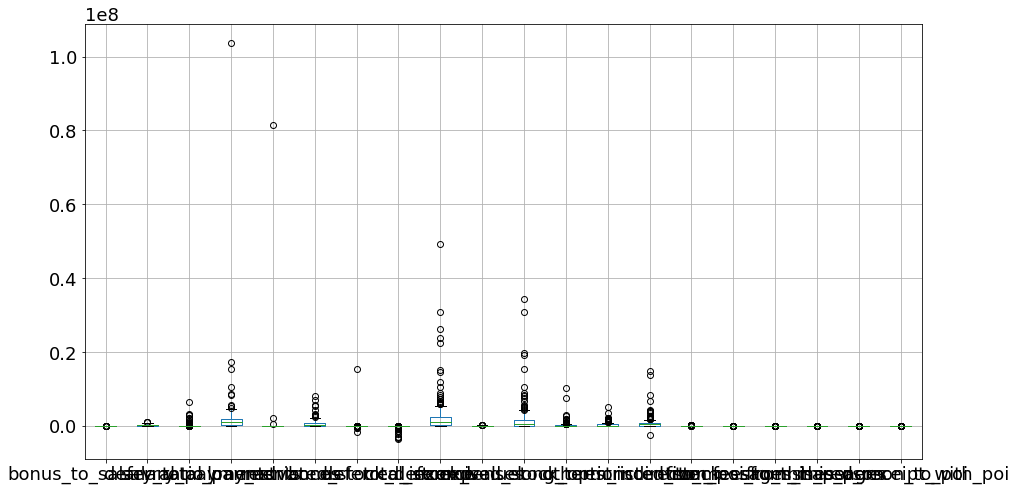

In [170]:
%matplotlib inline
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (15,8)

df.boxplot(features_list[1:])


In [171]:
df.shape
print(sum(df.poi == 1))

18


In [137]:
# # Check which rows have mostly zero values, which salaries are missing...
# # turns out it's most, so this was not useful.
# df.apply(lambda x: sum(x == 0), axis=1)
# df[df.salary == 0]
# sum(df.poi == 1)

# # Automatic outlier removal by standard deviation
# # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
# import numpy as np
# from scipy import stats
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# df.shape
# sum(df.poi == 1)

14

In [181]:
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.metrics import roc_curve, auc, confusion_matrix, fbeta_score, make_scorer

def run_logistic_regression_classifier(X_train, X_test, y_train, y_test, beta=1):
        
    X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled
    
    print "{} ({:.2f}%) positive labels in training set with resampling".format(len(y_train[y_train == True]), 100.0*len(y_train[y_train == True])/len(y_train))
    print "{} ({:.2f}%) positive labels in test set".format(len(y_test[y_test == True]), 100.0*len(y_test[y_test == True])/len(y_test))
    
    t0 = time()
    param_grid = {
             'C': [1e1, 1e2, 1e3, 1e4, 1e5, 1e6],
              'penalty': ['l1', 'l2'],
              }
    f5_scorer = make_scorer(fbeta_score, beta=beta)
    clf = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                       param_grid=param_grid,
                       scoring=f5_scorer)
    clf = clf.fit(X_train, y_train)
    print "training time: {}s".format(round(time() - t0, 3))
    print "Best estimator found by grid search:"
    print clf.best_estimator_
    
    y_pred = clf.predict(X_test)
    print "{} ({:.2f}%) positive labels in predictions".format(len(y_pred[y_pred == True]), 100.0*len(y_pred[y_pred == True])/len(y_pred))

    conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
    print conf
    TN, FP, FN, TP = conf.ravel()
    print "TN: {}, FP: {}, FN: {}, TP: {}".format(TN, FP, FN, TP)

    # accuracy: what proportion was correctly predicted out of total population?
    print "accuracy: {}".format((TP+TN)*1.0/(TN+FP+FN+TP))
    # precision: of all the ones you predicted to be of class X, what ratio was correct?
    print "precision: {}".format(TP*1.0/(TP+FP))
    # recall: of all the ones that ARE of class X, what ratio did you successfully predict?
    print "recall: {}".format(TP*1.0/(TP+FN))
    
    return clf.best_estimator_


def plot_roc(clf, X_test, y_test, X_train=None, y_train=None):
    y_score = clf.decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc)
    
    if X_train is not None and y_train is not None:
        y_score_train = clf.decision_function(X_train)
        
        # Compute ROC curve and ROC area for each class
        fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
        roc_auc_train = auc(fpr_train, tpr_train)

        plt.plot(fpr_train, tpr_train, color='aqua',
                 lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for Logistic Regression Model')
    plt.legend(loc="lower right")
    plt.show() 

Logistic Regression: SMOTE resampling
87 (50.00%) positive labels in training set with resampling
4 (9.09%) positive labels in test set
training time: 0.286s
Best estimator found by grid search:
LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
8 (18.18%) positive labels in predictions
[[35  5]
 [ 1  3]]
TN: 35, FP: 5, FN: 1, TP: 3
accuracy: 0.863636363636
precision: 0.375
recall: 0.75


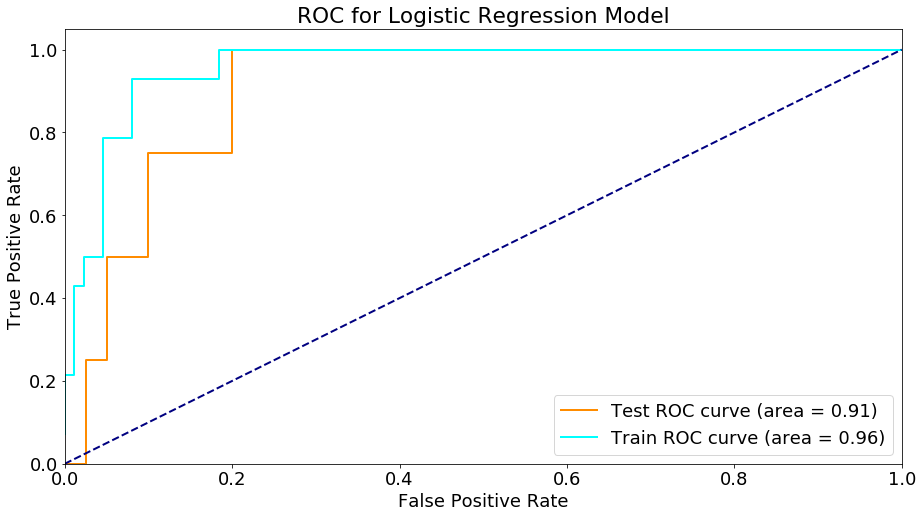

In [183]:
# SMOTE resampling
X = df[features_list[1:]]
y = df[features_list[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print "Logistic Regression: SMOTE resampling"
clf = run_logistic_regression_classifier(X_train, X_test, y_train, y_test)
plot_roc(clf, X_test, y_test, X_train, y_train)

3 features selected
Logistic Regression: reduced features
87 (50.00%) positive labels in training set with resampling
4 (9.09%) positive labels in test set
training time: 0.115s
Best estimator found by grid search:
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
13 (29.55%) positive labels in predictions
[[31  9]
 [ 0  4]]
TN: 31, FP: 9, FN: 0, TP: 4
accuracy: 0.795454545455
precision: 0.307692307692
recall: 1.0


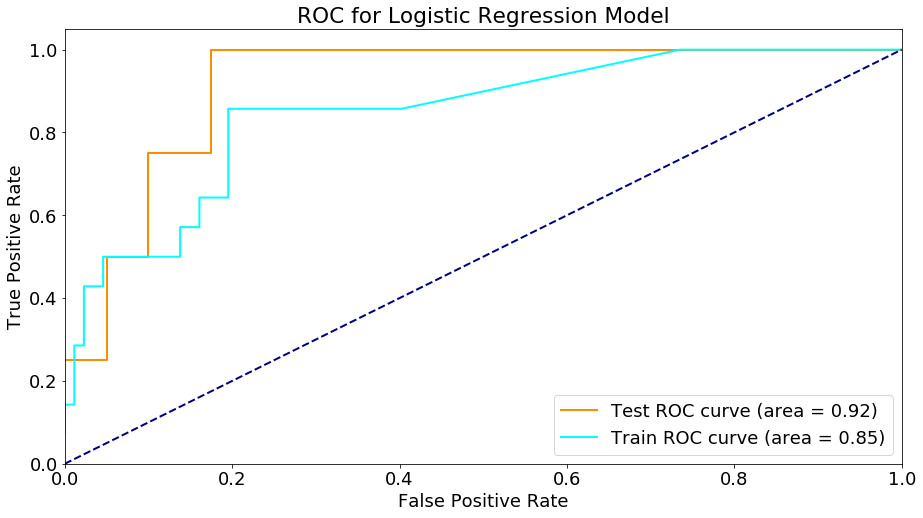

In [184]:
from sklearn.feature_selection import RFECV
selector = RFECV(clf, step=1)
selector = selector.fit(X_train, y_train)
print("{} features selected".format(selector.n_features_))

X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

print "Logistic Regression: reduced features"
clf = run_logistic_regression_classifier(X_train_reduced, X_test_reduced, y_train, y_test)
plot_roc(clf, X_test_reduced, y_test, X_train_reduced, y_train)

In [185]:
selector.support_

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False], dtype=bool)

In [167]:
from sklearn.model_selection import StratifiedShuffleSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    print(sum(labels))
    return
    cv = StratifiedShuffleSplit(n_splits = folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv.split(features, labels):
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


my_dict = df.to_dict(orient="index")      
test_classifier(clf, my_dict, features_list)

14.0


In [76]:
# https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
# Those values, however, will show that the second parameter
# is more influential
feature_weights = (df[df.columns[1:]].std().as_matrix() * clf.coef_)[0]
for idx, value in enumerate(feature_weights):
    if abs(value) > 10:
        print "Feature[{}] {}: {:.2f}".format(idx, df.columns[idx], value)

Feature[5] deferred_income: 23.70
Feature[7] expenses: -17.37
Feature[13] from_poi_to_this_person: -41.57
Feature[14] from_messages: 13.56


In [78]:
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer

def run_decision_tree_classifier(X_train, X_test, y_train, y_test, beta=5):
    print "{} ({:.2f}%) positive labels in training set".format(len(y_train[y_train == True]), 100.0*len(y_train[y_train == True])/len(y_train))
    print "{} ({:.2f}%) positive labels in test set".format(len(y_test[y_test == True]), 100.0*len(y_test[y_test == True])/len(y_test))

    t0 = time()
    param_grid = {
             'min_samples_split': [2,5,10,15,20],
             'max_depth': range(1,5,1),
              }
    f5_scorer = make_scorer(fbeta_score, beta=beta)
    clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                       param_grid=param_grid,
                       scoring=f5_scorer)
    clf = clf.fit(X_train, y_train)
    print "training time: {}s".format(round(time() - t0, 3))
    print "Best estimator found by grid search:"
    print clf.best_estimator_

    y_pred = clf.predict(X_test)
    print "{} ({:.2f}%) positive labels in predictions".format(len(y_pred[y_pred == True]), 100.0*len(y_pred[y_pred == True])/len(y_pred))

    conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
    print conf
    TN, FP, FN, TP = conf.ravel()
    print "TN: {}, FP: {}, FN: {}, TP: {}".format(TN, FP, FN, TP)

    # accuracy: what proportion was correctly predicted out of total population?
    print "accuracy: {}".format((TP+TN)*1.0/(TN+FP+FN+TP))
    # precision: of all the ones you predicted to be of class X, what ratio was correct?
    print "precision: {}".format(TP*1.0/(TP+FP))
    # recall: of all the ones that ARE of class X, what ratio did you successfully predict?
    print "recall: {}".format(TP*1.0/(TP+FN))
    
    return clf.best_estimator_


dt = run_decision_tree_classifier(X_train, X_test, y_train, y_test )
test_classifier(dt, my_dict, features_list)

13 (13.00%) positive labels in training set
5 (11.36%) positive labels in test set
training time: 0.258s
Best estimator found by grid search:
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
18 (40.91%) positive labels in predictions
[[24 15]
 [ 2  3]]
TN: 24, FP: 15, FN: 2, TP: 3
accuracy: 0.613636363636
precision: 0.166666666667
recall: 0.6
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'

In [87]:
print(dt.feature_importances_)
#11 13 17 19

features_list[1:][8]

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


'other'